# __Aproximação: Erros__

In [5]:
from IPython.display import Math
from random import uniform, randint

# CÓDIGOS DE REFERÊNCIA (Devem ser removidos antes da versão final!!)

## core.py

In [6]:
from typing import Callable, Optional, Sequence
import matplotlib.pyplot as plt

# Gostei muito da implementação dessas classes da lista 7 do professor então decidi implementar com pequenas modificações
class Domain:
    """
    Define o domínio no qual uma função real existe.
    """
    min = None
    max = None

    def __contains__(self, x):
        raise NotImplementedError
    
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()
    
    def copy(self):
        raise NotImplementedError 


class Interval(Domain):
    """
    Define um intervalo de números reais.
    """
    def __init__(self, p1, p2):
        self.inff, self.supp = min(p1, p2), max(p1, p2)
    
    @property
    def min(self):
        return self.inff

    @property
    def max(self):
        return self.supp
    
    @property
    def size(self):
        return (self.max - self.min)
    
    @property
    def half(self):
        return (self.max + self.min)/2.0
    
    def __contains__(self, other):
        if isinstance(other, Interval):
            return other.min >= self.min and other.max <= self.max
        elif isinstance(other, (float, int)):
            return self.min <= other <= self.max
        elif isinstance(other, Sequence):
            for i in other:
                if not (self.min <= i <= self.max):
                    return False
            return True
        else:
            return False


    def __str__(self):
        return f'[{self.min:2.4f}, {self.max:2.4f}]' 

    def __repr__(self):
        return f'[{self.min!r:2.4f}, {self.max!r:2.4f}]'
    
    def copy(self):
        return Interval(self.min, self.max)

    def intersect(self, other: 'Interval') -> Optional['Interval']:
        if not isinstance(other, Interval):
            return None
        
        newMin = max(self.min, other.min)
        newMax = min(self.max, other.max)
        return Interval(newMin,newMax) if newMin <= newMax else None

class RealFunction:
    """
    Classe abstrata que deve ser utilizada para implementação de funções reais, e.g. Polinomios
    """

    f: Callable[[float], float]
    prime: Optional[Callable[[float], float]]
    domain: Optional[Interval]
    
    def eval_safe(self, x):
        if self.domain is None or x in self.domain:
            return self.f(x)
        else:
            raise Exception("The number is out of the domain")

    def prime_safe(self, x):
        if self.prime is None:
            raise NotImplementedError("Derivative function (prime) is not defined for this function.")
        if self.domain is None or x in self.domain:
            return self.prime(x)
        else:
            raise Exception("The number is out of the domain")
        
    def __call__(self, x) -> float:
        return self.eval_safe(x)
    
    def plot(self, intervalo: Optional[Interval] = None, pontos: int = 100) -> tuple[plt.Figure, plt.Axes]:
        """
        Plota o gráfico da função real no intervalo especificado. Caso nenhum intervalo seja fornecido,
        será utilizado o domínio da função. Se o domínio da função também for None,uma exceção será 
        levantada. O número de pontos no gráfico poder ser ajustado, sendo 100 o padrão.

        Args:
            intervalo (Optional[Interval], optional): Intervalo para plotagem. Default é None.
            pontos (int, optional): Número de pontos no gráfico. Default é 100.
        Returns:
            tuple[plt.Figure, plt.Axes]: Figura e eixos do gráfico plotado.
        Examples:
            >>> f = Polinomio([1, -3, 2], Interval(0, 5))  # Representa P(x) = x^2 - 3x + 2
            >>> fig, ax = f.plot(Interval(0, 5), pontos=200)
            >>> plt.show()
        """
        dominio = self.domain
        if intervalo is not None:
            dominio = intervalo
        if dominio is None:
            raise Exception("Domínio da função não está definido.")
        fig, ax = plt.subplots()
        X = linspace(dominio.min, dominio.max, pontos)
        Y = [self(val) for val in X]
        ax.plot(X,Y)
        return fig, ax
    
def linspace(min: float, max: float, points: int) -> list[float]:
    """
    Retorna uma lista de pontos igualmente distribuídos em um intervalo

    Args:
        min (float): Valor mínimo do intervalo de pontos
        max (float): Vamor máximo do intervalo de pontos
        points (int): Quantidade de pontos

    Returns:
        list[float]: Lista de pontos igualmente distribuídos no intervalo

    Examples:
        >>> valores = linspace(0, 5, 6)
        >>> print(valores)
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    """
    if points < 2:
        return [min]
    step = (max - min) / (points - 1)
    return [(step * i + min) for i in range(points)]

def safe_intersect(d1: Optional['Interval'], d2: Optional['Interval']) -> Optional['Interval']:
    """
    Calcula a intersecção de dois intervalos, lidando com valores None.
    """
    if d1 is None or d2 is None:
        return None

    return d1.intersect(d2)

## polinomios.py

None
[0.0]
([2.0], [0.0])
[2.0, 5.0, 4.0, 8.0, 5.0, -3.0, 2.0, 4000.0]
[14.0, 30.0, 20.0, 32.0, 15.0, -6.0, 2.0]
107.0
None
9.0


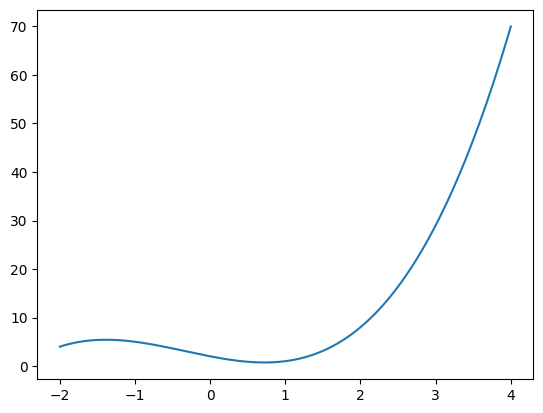

In [7]:
from typing import List, Tuple, Callable, Optional, cast
# Tentar executar localmente a partir da pasta geral do repositório vai dar erro, mas é assim mesmo que deve estar para o deploy.
# Se quiser testar localmente use o comando 'python -m CB2325NumericaG6.polinomios' sem as aspas.
# from .core import RealFunction, Interval, Domain, safe_intersect # CORRIGIR ERRO!!!
from sys import float_info

class Polinomio(RealFunction):
    """
    Representa um polinômio como uma lista de coeficientes, ordenados 
    do termo de **maior grau** para o termo constante.

    P[0] é o coeficiente do maior grau, e o grau é dado por len(P) - 1.
    Exemplo: O polinômio P(x) = 3x^2 + 2x - 1 é representado por [3.0, 2.0, -1.0].
    """

    # Importa o epsilon de maquina do sistema
    BASE_TOLERANCE = float_info.epsilon 

    def __init__(self, values: List[float], domain: Optional[Interval] = None):
        maxAbsCoeff = max((abs(v) for v in values), default=1.0)
        
        # Calcula a tolerância relativa para o polinomio
        self.TOLERANCE = self.BASE_TOLERANCE * maxAbsCoeff

        if self.TOLERANCE == 0.0:
            self.TOLERANCE = self.BASE_TOLERANCE

        self._values = [
            float(v) if abs(v) >= self.TOLERANCE else 0.0
            for v in values
        ]

        if self._values and abs(self._values[0]) < self.TOLERANCE:
            self._clearZeros()

        self.f = lambda x: self.evaluate(x)
        self.domain = domain
        self._primeFunc = None

    def __call__(self, x) -> float:
        return super().__call__(x)
    
    def __repr__(self):
        return str(self._values)
    
    def __len__(self):
        return len(self._values)
    
    def __getitem__(self, index: int):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("index out of range")
        elif index < 0:
            return self._values[size + index]
        else:
            return self._values[index]

    def __setitem__(self, index: int, value: float):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("assignment index out of range")
        elif index < 0:
            self._values[size + index] = value
        else:
            self._values[index] = value

    def _clearZeros(self):
        """
        Função interna para remover os 0s dos líderes
        """
        count = 0
        for coef in self._values:
            if coef == 0.0:
                count += 1
            else:
                break
        
        if count == len(self._values):
            self._values = []
        elif count> 0:
            self._values = self._values[count:]
        
        if not self._values:
            self._values.append(0.0)

    @property
    def degree(self) -> int:
        return len(self._values)-1
    
    @property
    def isZero(self) -> bool:
        return self._values == [0.0]
    
    @property
    def prime(self): # type: ignore
        if self._primeFunc is None:
            polinomio_derivado = self.diff()
            self._primeFunc = lambda x: polinomio_derivado.evaluate(x) 
        return self._primeFunc
    
    def evaluate(self, x: float) -> float:
        """
            Avalia o polinômio P(x) para um dado valor de x usando o Método de Horner.
            
            P é uma lista de coeficientes em ordem decrescente: [c_n, ..., c_0].
            
            Args:
                x (float): O ponto onde o polinômio será avaliado.
                
            Returns:
                float: O valor P(x).
            
            Examples:
                >>> P = Polinomio([2,3,4])
                >>> val = P.evaluate(1)
                >>> print(val)
                9

        """
        if not self._values:
            return 0.0

        resultado = self._values[0] 
        
        for i in range(1, len(self._values)):
            resultado = resultado * x + self._values[i]
            
        return resultado
    
    def __mul__(self, other: float | int) -> 'Polinomio':
        newValues = [c * float(other) for c in self._values]
        return Polinomio(newValues, self.domain)

    def __rmul__(self, other: float | int) -> 'Polinomio':
        return self.__mul__(other)
    
    def __neg__(self) -> 'Polinomio':
        new_values = [-c for c in self._values]
        return Polinomio(new_values, self.domain)
    
    def __add__(self, other: 'Polinomio') -> 'Polinomio':
        """Adição de polinômios: P1 + P2 (Começando pelo termo de maior grau)"""
        
        newDomain = safe_intersect(self.domain, other.domain)

        p1Coeffs = self._values
        p2Coeffs = other._values

        len1 = len(p1Coeffs)
        len2 = len(p2Coeffs)
        maxLen = max(len1, len2)
        
        newCoeffs = [0.0] * maxLen
        
        for i in range(maxLen):
            idx1 = len1 - 1 - i
            idx2 = len2 - 1 - i
            idx_res = maxLen - 1 - i
            
            c1 = p1Coeffs[idx1] if idx1 >= 0 else 0.0
            c2 = p2Coeffs[idx2] if idx2 >= 0 else 0.0
            
            newCoeffs[idx_res] = c1 + c2
            
        return Polinomio(newCoeffs, newDomain)
    
    def __sub__(self, other: 'Polinomio') -> 'Polinomio':
        negOther = -other 
        return self + negOther
    
    def __eq__(self, other) -> bool:
        #Assume que ambos não tem coeficiente líderes 0.
        if not isinstance(other, Polinomio):
            return NotImplemented
        return other._values == self._values

    def divideBy(self, divisor: 'Polinomio') -> Tuple['Polinomio', 'Polinomio']:
        """
            Realiza a divisão polinomial A / B (self / divisor) e retorna (Quociente, remainder).

            Args:
                divisor (Polinomio): Polinomio divisor
                tolerance (float, optional): Tolerância para checagem de zero, usado para
                    tratar erros de ponto flutuante. O valor padrão é 1e-12.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> p1 = Polinomio([4,6,8])
                >>> p2 = Polinomio([2,3,4])
                >>> print(p1.divideBy(p2))
                ([2.0], [0.0])
        """

        if divisor.degree < 0 or abs(divisor._values[0]) < self.TOLERANCE:
            raise ValueError("Cannot divide by the zero polynomial.")

        newDomain = safe_intersect(self.domain, divisor.domain)

        if self.degree < divisor.degree:
            return Polinomio([0.0], newDomain), Polinomio(self._values, newDomain)
        
        if divisor.degree == 0:
            constante_divisor = divisor._values[0]
            qCoeffs = [c / constante_divisor for c in self._values]
            return Polinomio(qCoeffs, newDomain), Polinomio([0.0], newDomain)

        mainDivisor = divisor._values[0]
        divisorDegree = divisor.degree
        
        quotientCoeffs = [0.0] * (self.degree - divisorDegree + 1)

        remainder = Polinomio(self._values) 
        
        while remainder.degree >= divisorDegree:
            mainRemainder = remainder._values[0]
            
            degreeDifference = remainder.degree - divisorDegree
            
            qCoeff = mainRemainder / mainDivisor

            qIdx = self.degree - remainder.degree
            quotientCoeffs[qIdx] = qCoeff
    
            multipliedTherm = divisor * qCoeff 

            shiftCoeffs = multipliedTherm._values + [0.0] * degreeDifference
            thermToSub = Polinomio(shiftCoeffs)

            remainder = remainder - thermToSub 

        if remainder.degree < 0:
            remainder = Polinomio([0.0], newDomain)

        return Polinomio(quotientCoeffs, newDomain), remainder
    
    def _getPNeg(self) -> 'Polinomio':
        """
        Cria e retorna o polinômio auxiliar P(-x).
        Isso inverte o sinal dos coeficientes dos termos de grau ímpar.
        """
        PNegCoeffs = []
        
        for i, coeff in enumerate(self._values):
            degree = self.degree - i

            if degree % 2 != 0:
                PNegCoeffs.append(-coeff)
            else:
                PNegCoeffs.append(coeff)
                
        return Polinomio(PNegCoeffs, self.domain)
    
    def getRealRootBounds(self) -> tuple[float, float]:
        """
            Calcula os limites superior positivo (L) e inferior negativo (l) 
            para todas as raízes reais do polinômio P(x)
            (Teorema dos Limites para Raízes de Polinômios (Cauchy Bound)).
        """
        if self.degree == 0:
            return 0.0, 0.0
        
        cn = self._values[0]
        cMax = max(abs(c) for c in self._values[1:]) if self.degree > 0 else 0.0
            
        if cMax == 0.0:
            L = 0.0
        else:
            L = 1.0 + (cMax / abs(cn))

        pNeg = self._getPNeg() 
        
        cnNeg = pNeg._values[0]
        cMaxNeg = max(abs(c) for c in pNeg._values[1:]) if pNeg.degree > 0 else 0.0
        
        if cMaxNeg == 0.0:
            Lneg = 0.0
        else:
            Lneg = 1.0 + (cMaxNeg / abs(cnNeg))

        l = -Lneg
        
        return l, L

    def diff(self) -> 'Polinomio':
        """
            Retorna a derivada de um polinomio.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> pol = Polinomio([-3.0,2.0,4.0])
                >>> dPol = pol.diff()
                >>> print(dPol)
                [-6.0,2.0]
        """

        if len(self) <= 1:
            return Polinomio([0])
        
        derivative = []

        for i in range(self.degree):
            derivative.append(self[i]*(self.degree-i))

        return Polinomio(derivative, self.domain)

def lambdify(P: 'Polinomio') -> Callable[[float], float]:
    """
    Cria e retorna uma função lambda (Callable) que avalia o polinômio P(x).
    
    Isso permite que o objeto Polinomio seja usado em métodos que esperam 
    uma função f(x), como Bisseção ou Secante.
    
    Args:
        P (Polinomio): O objeto Polinomio a ser convertido.
        
    Returns:
        Callable[[float], float]: Uma função lambda que recebe x (float) 
                                  e retorna P(x) (float).
    """
    
    def func_wrapper(x: float) -> float:
        """Função interna que avalia o polinômio P em x."""
        return P.evaluate(x)
        
    return func_wrapper

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    #Deve ignorar o primeiro coeficiente pois para o epsilon de máquina ele é zero.
    pol = Polinomio([0.0000000000001, 2,5,4,8,5,-3.0,2.0,4000])
    p1 = Polinomio([4,6,8], Interval(1,4))
    p2 = Polinomio([2,3,4], Interval(5,6))

    p3 = p1.divideBy(p2)

    print(p3[0].domain)

    print(p2*2 - p1)
    print(p3)

    print(pol)
    dPol = pol.diff()
    print(dPol)
    print(pol.prime(1))
    print(dPol.domain)

    print(p2.evaluate(1))

    polinomio = Polinomio([1, 1, -3, 2], Interval(-6,6))  # Representa P(x) = x^2 - 3x + 2
    polinomio.plot(Interval(-2, 4), pontos=200)
    plt.show()

## aproximacao.py

In [8]:
import math
import statistics
# from polinomios import Polinomio
# CORRIGIR PROBLEMA ANTES DA VERSÃO FINAL!!!
import numpy as np

def ajuste_linear(x: list[float], y: list[float]) -> Polinomio:
    """
    Ajusta y = a*x + b aos pontos (x, y) por mínimos quadrados (erro vertical).

    Args:
        x: Valores da variável independente.
        y: Valores da variável dependente (mesmo tamanho de x).

    Returns:
        Polinomio: Classe Polinomio contendo os coeficientes

    Raises:
        ValueError: Tamanhos diferentes ou menos de dois pontos.
        ZeroDivisionError: Variância de x igual a zero.
    """
    n = len(x)
    if n != len(y):
        raise ValueError("Ambas as listas devem ter o mesmo tamanho.")
    if n < 2:
        raise ValueError("Precisa de pelo menos dois pontos.")

    mx = statistics.mean(x)
    my = statistics.mean(y)

    cov_xy = math.fsum((xi - mx) * (yi - my) for xi, yi in zip(x, y))
    var_x  = math.fsum((xi - mx) ** 2 for xi in x)

    if var_x == 0.0:
        raise ZeroDivisionError("A variância de x é zero.")

    a = cov_xy / var_x
    b = my - a * mx
    return Polinomio([a,b])

def ajuste_polinomial(x: list[float], y: list[float], n = 2, precisao = 5) -> Polinomio:
    """
    Ajusta y = a_0*x^n + a_1*x^(n-1) + ... + a_n aos pontos (x,y) por mínimos quadrados (erro vertical)

    Args:
        x: Valores da variável independente.
        y: Valores da variável dependente (mesmo tamanho de x).

    Returns:
        Polinomio: Classe Polinomio contendo os coeficientes

    Raises:
        ValueError: Tamanhos diferentes, menos de dois pontos ou grau inadequado.
        ZeroDivisionError: Variância de x igual a zero.
    """

    if len(x) != len(y):
        raise ValueError("Ambas as listas devem ter o mesmo tamanho.")
    if len(x) < 2:
        raise ValueError("Precisa de pelo menos dois pontos.")
    if n > len(x) - 1:
        raise ValueError("O grau do polinomio deve ser menor que o numero de pontos.")
    X = np.array(x)
    Y = np.array(y)
    Coeficientes = np.polyfit(X,Y,n)
    Poly = Polinomio([round(Coeficientes[i],precisao) for i in range(len(Coeficientes))])
    return Poly

if __name__ == "__main__":
    x = [0, 1, 2, 3, 4]
    y = [1.1, 1.9, 3.0, 3.9, 5.2]

    Px = ajuste_linear(x,y)
    print("Ajuste Linear: ", f"y = {Px[0]:.2f}x + {Px[1]:.2f}")
    Px_2 = ajuste_polinomial(x,y,2)
    Px_3 = ajuste_polinomial(x,y,3)
    print("Ajuste quadrático:",f"y = {Px_2[0]:.2f}x^2 + {Px_2[1]:.2f}x + {Px_2[2]:.2f}")
    print("Ajuste cúbico:",f"y = {Px_3[0]:.2f}x^3 + {Px_3[1]:.2f}x^2 + {Px_3[2]:.2f}x + {Px_3[3]:.2f}")

Ajuste Linear:  y = 1.02x + 0.98
Ajuste quadrático: y = 0.06x^2 + 0.79x + 1.09
Ajuste cúbico: y = 0.01x^3 + 0.01x^2 + 0.86x + 1.08


# __Exemplos__

---

## Exemplo 1:

In [9]:
x = [0,1,2,3,4]
y = [1.1, 1.9, 3.0, 3.9, 5.2]

a,b = ajuste_linear(x,y)

print(f'A função de aproximação é dada por:')
display(Math(f'y = {a:.2f}x + {b:.2f}'))

# IMPLEMENTAR PARTE GRÁFICA (ESSENCIAL)!!

A função de aproximação é dada por:


<IPython.core.display.Math object>

---

## Exemplo 2:

In [10]:
x = [0, 1, 2, 3, 4]
y = [1, 3, 5, 7, 9]

a,b = ajuste_linear(x,y)

print(f'A função de aproximação é dada por:')
display(Math(f'y = {a:.2f}x + {b:.2f}'))

# IMPLEMENTAR PARTE GRÁFICA (ESSENCIAL)!!

A função de aproximação é dada por:


<IPython.core.display.Math object>

---

## Exemplo 3:

In [14]:
x = [1, 2, 3, 4, 5]
y = [5, 5, 5, 5, 4.9]

a,b = ajuste_linear(x,y)

print(f'A função de aproximação é dada por:')
display(Math(f'y = {a:.2f}x + {b:.2f}'))

# IMPLEMENTAR PARTE GRÁFICA (ESSENCIAL)!!

A função de aproximação é dada por:


<IPython.core.display.Math object>

---

## Exemplo 4:

In [ ]:
x = [10, 20]
y = [10, 20]

a,b = ajuste_linear(x,y)

print(f'A função de aproximação é dada por:')
display(Math(f'y = {a:.2f}x + {b:.2f}'))

# IMPLEMENTAR PARTE GRÁFICA (ESSENCIAL)!!

A função de aproximação é dada por:


<IPython.core.display.Math object>

---

## Exemplo 5:
Gera $n \in [2,50]$ pontos aleatórios entre $-10$ e $10$, e faz a aproximação linear

In [22]:
n = randint(2, 50)

x = [uniform(-10, 10) for k in range(n)]
y = [uniform(-10, 10) for k in range(n)]

a,b = ajuste_linear(x,y)

print(f'A função de aproximação é dada por:')
display(Math(f'y = {a:.2f}x + {b:.2f}'))

# IMPLEMENTAR PARTE GRÁFICA (ESSENCIAL)!!

A função de aproximação é dada por:


<IPython.core.display.Math object>

---